In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import zipfile as zf
import os
import csv
import gc
import operator
import random
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split deprec
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from random import shuffle
from IPython.display import Image
from pathlib import Path
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
import keras.backend as K
#from tensorflow.python.framework import ops ops.reset_default_graph()
from keras.models import Sequential
from keras import optimizers

#chargement du jeu de données d'entrainement
trainData = pd.read_csv("C:/Users/stephane.scheid/Anaconda3/Project/Whales-master/train.csv")

#affichage de quelques exemples
trainData.sample(5)

,Image,Id
2211,3998e5cd.jpg,w_11c2836
4686,79bb7b6d.jpg,w_8459e39
4711,7a99c7df.jpg,w_4fd48e7
9425,f5148700.jpg,w_be3c0f5
5877,9855e275.jpg,w_81b402a


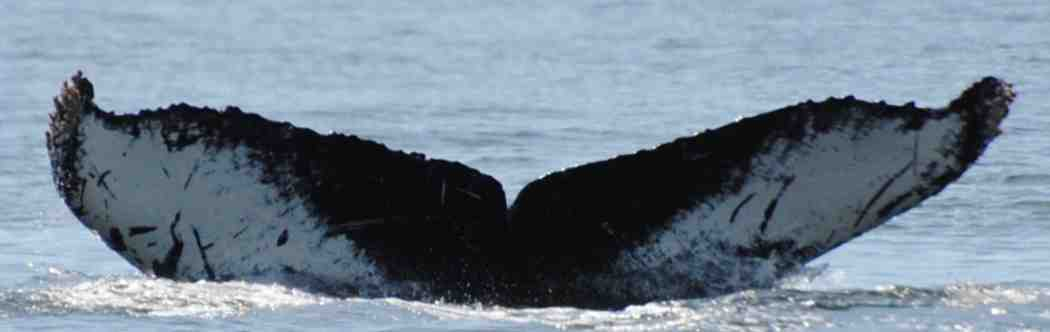

In [27]:
#affichage d'une image aleatoire
Image(filename="C:/Users/stephane.scheid/Anaconda3/Project/Whales-master/train/"+random.choice(trainData['Image'])) 

In [28]:
def prepareImages(data, m, dataset):
    
    print("Preparing images")
    
    X_train = np.zeros((m, 100, 100, 3))
    
    count = 0
    
    for fig in data['Image']:
        #on charge les images sous forme d'image de taille 100x100x3 
        img = image.load_img("C:/Users/stephane.scheid/Anaconda3/Project/Whales-master/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    count = 0
    print("Finished!")
    
            
    return X_train

In [29]:
def prepareY(Y):

    values = array(Y)
    print(values.shape)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)

    y = onehot_encoded
    print(y.shape)
    return y, label_encoder

#lzq lignes suivantes sont la pour tester le code, pas besoin de les charger pour test le modele
#inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)

In [30]:
#definition du model
mod = Sequential()

#on utilise conv2d et on definis la taille des entrée par 100 / 100 / 3 
#pour correspondre a la taille qu'on a donner aux images
#le jeux aillant des images de tailles differentes on a du les resize
mod.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

#on normalise pour accelerer le traitement
mod.add(BatchNormalization(axis = 3, name = 'bn0'))
mod.add(Activation('relu'))
mod.add(MaxPooling2D((2, 2), name='max_pool'))

#on utilise Conv2D comme reseau de neurone convolutione
#le plus optimiser pour des traitements d'images 
mod.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
mod.add(Activation('relu'))
mod.add(AveragePooling2D((3, 3), name='avg_pool'))

#on aplatis les images pour pouvoir travailler de manière vectorielle
mod.add(Flatten())

#premiere couche de 500 neurones
mod.add(Dense(500, activation="relu", name='rl'))

#on a 0.8 de dropout, seul 20 % des neurones seront 
#effectif de manière aléatoire a chaque passage
mod.add(Dropout(0.8))

#derniere couche de sortie de 4251 neurones avec softmax comme fonctiond 'activation'
mod.add(Dense(4251, activation='softmax', name='sm'))

print(mod.output_shape)

#test opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mod.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

(None, 4251)


In [6]:
X = prepareImages(trainData, 9850, "train")

#put all the values of the training data in the range between 0 and 1
X /= 255

print("Shape X-train: ", X.shape)

Preparing images
Processing image:  1 ,  00022e1a.jpg
Processing image:  501 ,  0c64ae81.jpg
Processing image:  1001 ,  19546e12.jpg
Processing image:  1501 ,  27e1c585.jpg
Processing image:  2001 ,  34453b91.jpg
Processing image:  2501 ,  414cb204.jpg
Processing image:  3001 ,  4e7b614f.jpg
Processing image:  3501 ,  5b1823d1.jpg
Processing image:  4001 ,  68d47887.jpg
Processing image:  4501 ,  74f20dc3.jpg
Processing image:  5001 ,  81c129dd.jpg
Processing image:  5501 ,  8e84444c.jpg
Processing image:  6001 ,  9c8173f2.jpg
Processing image:  6501 ,  a899eaba.jpg
Processing image:  7001 ,  b5c23b76.jpg
Processing image:  7501 ,  c25a929e.jpg
Processing image:  8001 ,  cf839e92.jpg
Processing image:  8501 ,  dcfa710f.jpg
Processing image:  9001 ,  ea462ed5.jpg
Processing image:  9501 ,  f70aaa64.jpg
Finished!
Shape X-train:  (9850, 100, 100, 3)


In [31]:
Y = trainData['Id']

print("Shape Y-train: ", Y.shape)

#Lignes de test, non necessaire T
#labels = trainData['Id'].unique()
#print("Labels in data set: ", labels.shape)
#labelsTrain = Y.unique()
#print("Labels in training set: ", labelsTrain.shape)

y, label_encoder = prepareY(Y)

Shape Y-train:  (9850,)
(9850,)
[3741  310 3613 ... 2337  746 3088]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(9850, 4251)


C:\Users\stephane.scheid\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
#affiche le résumé du model avec les differentes couches
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [10]:
#100 epoch et 100 batch
#a executer pour l'entrainement, nous vous avons sauvegarder le model dans un fichier deux cases plus bas
history = mod.fit(X, y, epochs=100, batch_size=100, verbose=1,)
gc.collect()

Epoch 1/100
9850/9850 [==============================] - 275s 28ms/step - loss: 2.6773 - acc: 0.7254
Epoch 2/100
9850/9850 [==============================] - 276s 28ms/step - loss: 2.5115 - acc: 0.7245
Epoch 3/100
9850/9850 [==============================] - 270s 27ms/step - loss: 2.3547 - acc: 0.7319
Epoch 4/100
9850/9850 [==============================] - 270s 27ms/step - loss: 2.2487 - acc: 0.7403
Epoch 5/100
9850/9850 [==============================] - 269s 27ms/step - loss: 2.1273 - acc: 0.7435
Epoch 6/100
9850/9850 [==============================] - 268s 27ms/step - loss: 1.9850 - acc: 0.7522
Epoch 7/100
9850/9850 [==============================] - 269s 27ms/step - loss: 1.9116 - acc: 0.7528
Epoch 8/100
9850/9850 [==============================] - 270s 27ms/step - loss: 1.8194 - acc: 0.7596
Epoch 9/100
9850/9850 [==============================] - 270s 27ms/step - loss: 1.7032 - acc: 0.7658
Epoch 10/100
9850/9850 [==============================] - 270s 27ms/step - loss: 1.6142 - a

7782

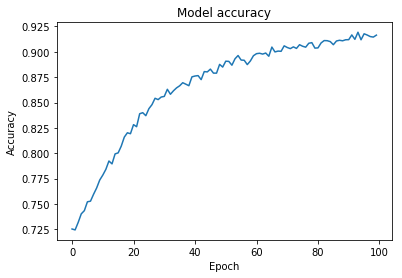

In [32]:
#affichage de l'accuracy au cours de l'entrainement du modele
#but : ameliorer le model et verifier l'overfiting, pour cela on a ajouter un jeux de validation (0.2% des données)
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [33]:
#on save le model car /il met une dizaine d'heure a tourner
#mod.save("modelrendu.h5")

#pour charger le model et effectuer le test et la generation du resultat il faut load tout le projet sans 
#l'entrainement puis executer la ligne de desous pour recuperer le model que nous avons entrainer(pour eviter les 10h d'entrainement)
#mod = load_model('modelsavepoid.h5')

In [35]:
#on ouvre les données de test
test = os.listdir("C:/Users/stephane.scheid/Anaconda3/Project/Whales-master/test")
print(len(test))

#on separe les données en plusieurs dataframe a cause de contraintes de memoire :( 
col = ['Image']
testData1 = pd.DataFrame(test[0:3899], columns=col)
testData2 = pd.DataFrame(test[3900:7799], columns=col)
testData3 = pd.DataFrame(test[7800:11699], columns=col)
testData4 = pd.DataFrame(test[11700:15609], columns=col)
testData = pd.DataFrame(test, columns=col)

2785


In [36]:
#X_test = prepareImages(testData1, 15610, "test")
gc.collect()
X = prepareImages(testData1, 3900, "test")
X /= 255

Preparing images
Processing image:  1 ,  0010a672.jpg
Processing image:  501 ,  3132b00a.jpg
Processing image:  1001 ,  6015aeab.jpg
Processing image:  1501 ,  8b04e9e4.jpg
Processing image:  2001 ,  b75a4cc3.jpg
Processing image:  2501 ,  e4b6a768.jpg
Finished!


In [37]:
predictions1 = mod.predict(np.array(X), verbose=1)
gc.collect()

3900/3900 [==============================] - 66s 17ms/step


0

In [38]:
X = prepareImages(testData2, 3900, "test")
X /= 255
predictions2 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Finished!
3900/3900 [==============================] - 65s 17ms/step


0

In [39]:
X = prepareImages(testData3, 3900, "test")
X /= 255
predictions3 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Finished!
3900/3900 [==============================] - 67s 17ms/step


0

In [18]:
X = prepareImages(testData4, 3910, "test")
X /= 255
predictions4 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Finished!
3910/3910 [==============================] - 69s 18ms/step


0

In [40]:
#on concatene les predictions en un seul vecteur
predictions = np.concatenate((predictions1, predictions2), axis=0)
predictions = np.concatenate((predictions, predictions3), axis=0)
predictions = np.concatenate((predictions, predictions4), axis=0)
gc.collect()
print(predictions.shape)
print(predictions)

(15610, 4251)
[[2.4488385e-04 2.3035186e-04 2.4099572e-04 ... 2.2713559e-04
  2.3507691e-04 2.2867453e-04]
 [2.3791683e-04 2.3334095e-04 2.4188901e-04 ... 2.3389909e-04
  2.3592512e-04 2.3526652e-04]
 [2.3780332e-04 2.3642113e-04 2.4710468e-04 ... 2.3172294e-04
  2.3244451e-04 2.3147072e-04]
 ...
 [2.8210562e-01 8.0371297e-05 4.0055520e-06 ... 3.0702220e-05
  4.7299603e-05 2.1295330e-06]
 [2.8210562e-01 8.0371297e-05 4.0055520e-06 ... 3.0702278e-05
  4.7299694e-05 2.1295371e-06]
 [2.8210562e-01 8.0371297e-05 4.0055520e-06 ... 3.0702278e-05
  4.7299698e-05 2.1295371e-06]]


In [41]:
#on choisit les predictions avec la lus haute probabilité et pour chaque valeur on definit la probabilité a 0 pour ne pas qu'elle sois choisit de nouveau.
print(predictions.shape)

copy_pred = np.copy(predictions)
idx = np.argmax(copy_pred, axis=1)
copy_pred[:,idx] = 0
idx2 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx2] = 0
idx3 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx3] = 0
idx4 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx4] = 0
idx5 = np.argmax(copy_pred, axis=1)

(15610, 4251)


In [42]:
#convert the one-hot vectors to their names
results = []

print(idx[0:10])
print(idx2[0:10])
print(idx3[0:10])
print(idx4[0:10])
print(idx5[0:10])
threshold = 0.05 #threshold - only consider answers with a probability higher than it
for i in range(0, predictions.shape[0]):
#for i in range(0, 10):
    each = np.zeros((4251, 1))
    each2 = np.zeros((4251, 1))
    each3 = np.zeros((4251, 1))
    each4 = np.zeros((4251, 1))
    each5 = np.zeros((4251, 1))
    if((predictions[i, idx5[i]] > threshold)):
        each5[idx5[i]] = 1
        each4[idx4[i]] = 1
        each3[idx3[i]] = 1
        each2[idx2[i]] = 1
        each[idx[i]] = 1
        tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0], label_encoder.inverse_transform([argmax(each5)])[0]]
    else:
        if((predictions[i, idx4[i]] > threshold)):
            print(predictions[i, idx4[i]])
            each4[idx4[i]] = 1
            each3[idx3[i]] = 1
            each2[idx2[i]] = 1
            each[idx[i]] = 1
            tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0]]
        else:
            if((predictions[i, idx3[i]] > threshold)):
                each3[idx3[i]] = 1
                each2[idx2[i]] = 1
                each[idx[i]] = 1
                tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0]]
            else:
                if((predictions[i, idx2[i]] > threshold)):
                    each2[idx2[i]] = 1
                    each[idx[i]] = 1
                    tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0]]
                else:
                    each[idx[i]] = 1
                    tags = label_encoder.inverse_transform([argmax(each)])[0]
    results.append(tags)


[1840 1690 1690 3583 1840  531 3033 3583 2163 1690]
[4166 2634  347 1904 2992  374  200  597 2174 3600]
[1794 3452 1763 4227 3307 3840  383 1122  448 1183]
[3632   64 1265 2251 2118 4033 1167 1010 2242 3902]
[4184 3222 3016  874 3055 4155 3851 1066 1702 3500]
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119

0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.05

0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.05

0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.05

0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.052119736
0.05

In [22]:
#on ecris les previsions dans un fichier
myfile = open('output.csv','w')

column= ['Image', 'Id']

wrtr = csv.writer(myfile, delimiter=',')
wrtr.writerow(column)

for i in range(0, testData.shape[0]):
    pred = ""
    if(len(results[i])==5):
        if (results[i][4]!=results[i][0]):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3] + " " + results[i][4]
        else:
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
    else:
        if(len(results[i])==4):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
        else:
            if(len(results[i])==3):
                pred = results[i][0] + " " + results[i][1] + " " + results[i][2]
            else:
                if(len(results[i])==2):
                    pred = results[i][0] + " " + results[i][1]
                else:
                    pred = results[i]
            
    result = [testData['Image'][i], pred]
    #print(result)
    wrtr.writerow(result)
    
myfile.close()